# Clase Práctica 11

# Neural Network - LSTM

# Predicción de señales temporales

En este clase práctica, vamos a aplicar una red LSTM para predecir diferentes valores de una señal temporal. 

# Librerías

Se deben incluir las librerías para redes neuronales recurrentes, en este caso LSTM. 

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import ConvLSTM2D
from keras.layers import Flatten

Using TensorFlow backend.


# Importando los datos

Se uiliza pandas para leer los datos en csv. Para este ejemplo, vamos a cargar una señal sinusoidal y vamos a tratar de predecir el siguiente dato. Para realizar esto, vamos a incluir diferentes tamaños de bloques de entrada para predecir su salida. 

(5001, 1)


Text(0.5,1,'serie de tiempo')

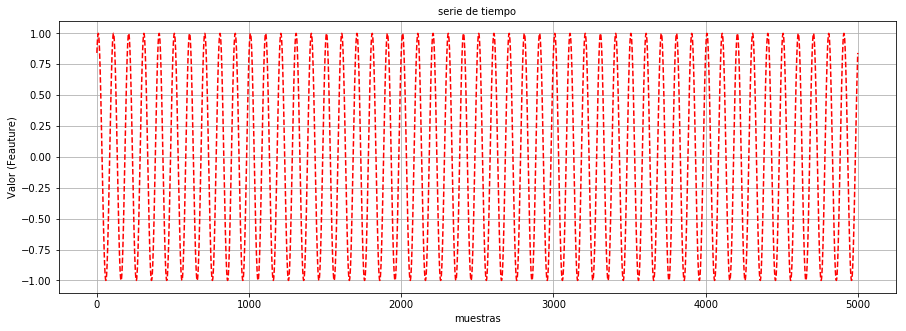

In [2]:
datos = pd.read_csv('sine wave.csv', header=None )
#datos = pd.read_csv('corona_chile.csv', header=None )

dataset = datos.values
dataset = dataset.astype('float32')

señal = dataset
print(señal.shape)
plt.figure(figsize=[15,5])
plt.grid()
plt.plot(señal, '--r')
plt.xlabel("muestras",fontsize = 10)
plt.ylabel("Valor (Feauture)",fontsize = 10)
plt.title("serie de tiempo", fontsize = 10)

# Normalización

Recordar que las redes neuronales trabajan mejor con números entre 0 y 1, ó -1 y 1, así que generalmente hay que normalizar los datos. Para esto usaremos la función MinMaxScaler. 

(5001, 1)


Text(0.5,1,'serie de tiempo')

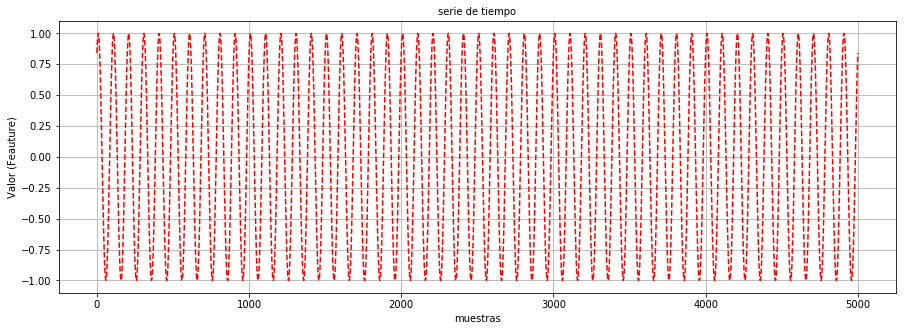

In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))  # no es necesario normalizar la sinusoide
señal2 = scaler.fit_transform(señal)
print(señal2.shape)
plt.figure(figsize=[15,5])
plt.grid()
plt.plot(señal2, '--r')
plt.xlabel("muestras",fontsize = 10)
plt.ylabel("Valor (Feauture)",fontsize = 10)
plt.title("serie de tiempo", fontsize = 10)

# Separación de datos de train, val y test. 

In [4]:
# generar conjuntos
porcentaje = 0.8
train_size = int(len(señal2) * porcentaje)
test_size = len(señal2) - train_size
train, test = señal2[0:train_size,:], señal2[train_size:len(señal2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

4000 1001
(4000, 1)
(1001, 1)


In [5]:
# val
train_size1 = int(len(train) * porcentaje)
val_size = len(train) - train_size1
train, val = train[0:train_size1,:], train[train_size1:len(señal2),:]

print("los conjuntos quedan: train:", len(train), ", val: ", len(val),  ", test: ", len(test))
print(train.shape)
print(val.shape)
print(test.shape)

los conjuntos quedan: train: 3200 , val:  800 , test:  1001
(3200, 1)
(800, 1)
(1001, 1)


# Función para generaar las secuencias de datos para la red

La siguiente función convierte nuestros datos en una secuencia de ventanas para generar los datos que ingresan a la red. El parametro n_step indica el largo de la ventana de datos de entrada que le entregaremos a la red. El parámetro n_step_out nos indica cuantas etiquetas de salidas quieren ser predecidas. 

In [6]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
n_steps_in = 2   # ventana de n datos de entrada 
n_steps_out = 1  # n predicciones 
n_features = 1   # solo un feature (no cambiar en este ejemplo)

In [8]:
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)   # generamos la división
valX, valY = split_sequence(val, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

# Revisión de los datos

In [9]:
for i in range(3):
    print(trainX[i], trainY[i])
    print("")

[[0.8414828 ]
 [0.87374866]] [[0.90256625]]

[[0.87374866]
 [0.90256625]] [[0.9278218]]

[[0.90256625]
 [0.9278218 ]] [[0.9494157]]



Ahora arreglamos las etiquetas el formato que pide la red LSTM

In [23]:
trainY = np.reshape(trainY, (trainY.shape[0],trainY.shape[1]))
valY = np.reshape(valY, (valY.shape[0],valY.shape[1]))
testY = np.reshape(testY, (testY.shape[0],testY.shape[1]))

# Modelo de red neuronal LSTM

Se genera una función para llamar a la red LSTM. Note que la red LSTM le ingresan n entradas con una característica cada una. Se utilizan funciones de activación ReLu. Note que la salida depende de la cantidad de etiquetas que vamos a predecir, en este caso igual a n_step_out. 

In [11]:
# network
output_dim= 100

def modelo_lstm():
    model = Sequential()
    model.add(LSTM(output_dim, activation='relu', input_shape=(n_steps_in, n_features)))
    #model.add(Dropout(0.5))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer='RMSprop', metrics=['mse', 'mae'])
    return model

# Ajustar modelo

In [12]:
batch_size= 32
epochs= 15

model = modelo_lstm()
model.summary()
start = time.time()

history = model.fit(trainX, trainY, batch_size=batch_size, epochs= epochs, validation_data=(valX,valY))

print("> tiempro entrenando... : ", time.time() - start)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 42,433
Trainable params: 42,433
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 3198 samples, validate on 798 samples
Epoch 1/15
3198/3198 [==============================] - 4s 1ms/step - loss: 0.1679 - mean_squared_error: 0.1679 - mean_absolute_error: 0.3056 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0665
Epoch 2

# Algunos gráficos

Se presentan los gráficos con el rendimiento de la red para el entrenamiento y validación. Se utilizan dos métricas para evaluar modelos que ya hemos estudiando anteriormente, el MSE y el MAE. 

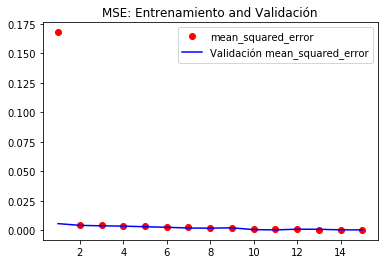

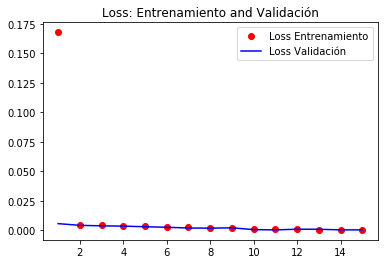

In [13]:
mae = history.history['mean_squared_error']
val_mae = history.history['val_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae , 'ro', label='mean_squared_error')
plt.plot(epochs, val_mae , 'b', label='Validación mean_squared_error')
plt.title('MSE: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig1.png")

# gráfico para la pérdida obtenido de los datos de la historia 
plt.figure()
plt.plot(epochs, loss, 'ro', label='Loss Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Loss Validación')
plt.title('Loss: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig2.png")
plt.show()

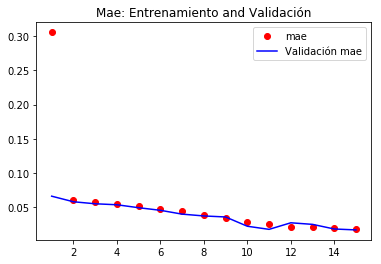

In [14]:
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae , 'ro', label='mae')
plt.plot(epochs, val_mae , 'b', label='Validación mae')
plt.title('Mae: Entrenamiento and Validación')
plt.legend()
plt.savefig("Fig1.png")


# Predicciones

Las predicciones se realizan como de costumbre con model.predict. En este ejemplo se utilizan las predicciones para todos los sets de datos (train, val, test). Es muy importante aplicar la normalización inversa para volver a los datos reales. 

In [15]:
# predicciones de los valores de entrenamiento y prueba 
trainPredict = model.predict(trainX)
valPredict = model.predict(valX)
testPredict = model.predict(testX)

# desnormalizar
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

valPredict = scaler.inverse_transform(valPredict)
valY = scaler.inverse_transform(valY)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


# Puntajes

In [16]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.8f RMSE' % (trainScore))

valScore = math.sqrt(mean_squared_error(valY, valPredict))
print('Test Score: %.8f RMSE' % (valScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.8f RMSE' % (testScore))

Train Score: 0.02011910 RMSE
Test Score: 0.02008196 RMSE
Test Score: 0.02011123 RMSE


In [17]:
print('MAE del entrenamiento promedio: %.8f MAE' % (np.mean(mae)))

trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.8f MAE' % (trainScore))

valScore = mean_absolute_error(valY, valPredict)
print('Val Score: %.8f MAE' % (valScore))

testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.8f MAE' % (testScore))

MAE del entrenamiento promedio: 0.05565913 MAE
Train Score: 0.01731099 MAE
Val Score: 0.01727844 MAE
Test Score: 0.01730422 MAE


In [18]:
score = model.evaluate(testX , testPredict)
print(score)

999/999 [==============================] - 0s 119us/step
[9.578311095694049e-11, 9.578311095694049e-11, 8.796726448068526e-06]


# Predicciones futuras

Text(0.5,1,'Gráfico de predicciones vs datos reales')

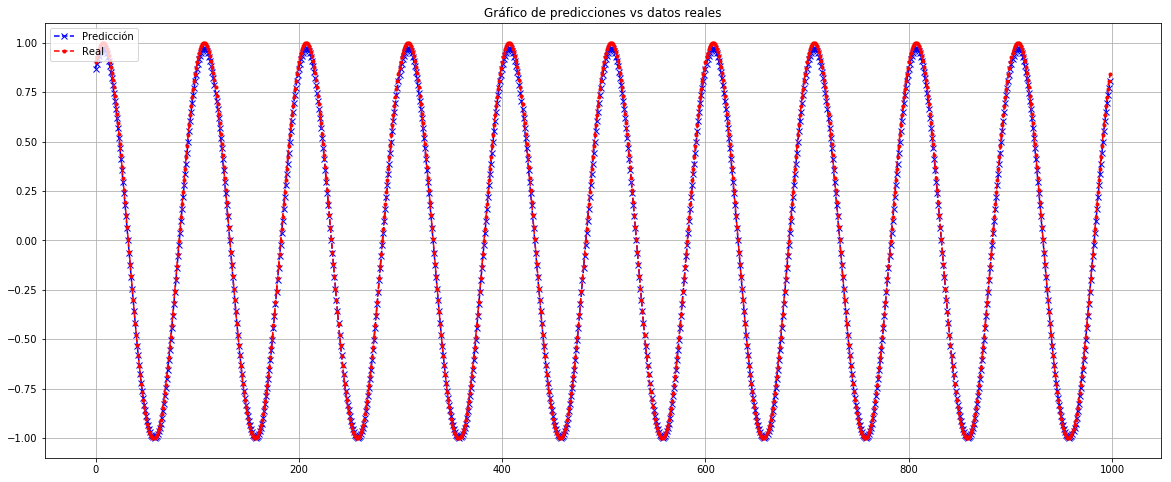

In [19]:
plt.figure(figsize=[20,8])
plt.plot(testPredict ,'b--x', label="Predicción")
plt.plot(testY, 'r--.', label="Real")
plt.grid()
plt.legend(loc='upper left')
plt.title("Gráfico de predicciones vs datos reales", fontsize = 12)

# Revisión de predicciones en toda la señal

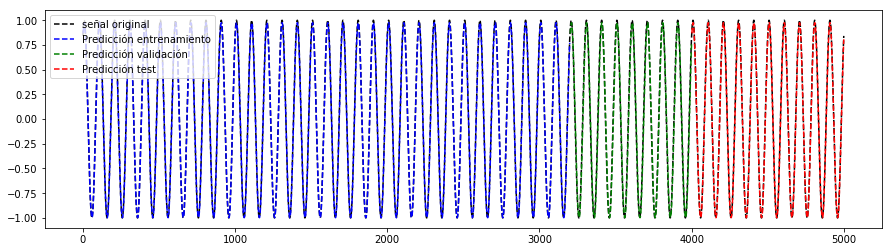

In [20]:
import numpy

trainPredictPlot = numpy.empty_like(señal2)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[n_steps_in : len(trainPredict) + n_steps_in, :] = trainPredict


valPredictPlot = numpy.empty_like(señal2)
valPredictPlot[:, :] = numpy.nan
valPredictPlot[len(trainPredict) + (n_steps_in*2) + 1 : len(trainPredict) + (n_steps_in*2) + 1+  len(valPredict) , :] = valPredict

testPredictPlot = numpy.empty_like(señal2)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict) + (n_steps_in*2) + 1 +  len(valPredict) +1 : len(señal2)-n_steps_in+2 , :] = testPredict

plt.figure(figsize=[15, 4])
plt.plot(scaler.inverse_transform(señal2),'k--', label="señal original" )
plt.plot(trainPredictPlot, 'b--', label="Predicción entrenamiento")
plt.plot(valPredictPlot, 'g--', label="Predicción validación")
plt.plot(testPredictPlot, 'r--', label="Predicción test")
plt.legend(loc='upper left')
plt.show()

# Ejemplos de predicción aleatorea

In [21]:
indice = np.random.choice(list(range(len(testX))), 1)[0]
sample = np.reshape(testX[indice], (1, testX.shape[1], testX.shape[2]))
prediccion = model.predict(sample) 
prediccion = scaler.inverse_transform(prediccion)
etiqueta_real = testY[indice]

print(" entrada", testX[indice])
print("")
print("Comparación de una predicción aleatoria")
print()
print("Valor de la etiqueta real:")
print(etiqueta_real)
print()
print("Valor de la predicción:")
print(prediccion[0])

 entrada [[0.77389777]
 [0.7326034 ]]

Comparación de una predicción aleatoria

Valor de la etiqueta real:
[0.688408]

Valor de la predicción:
[0.66495115]
